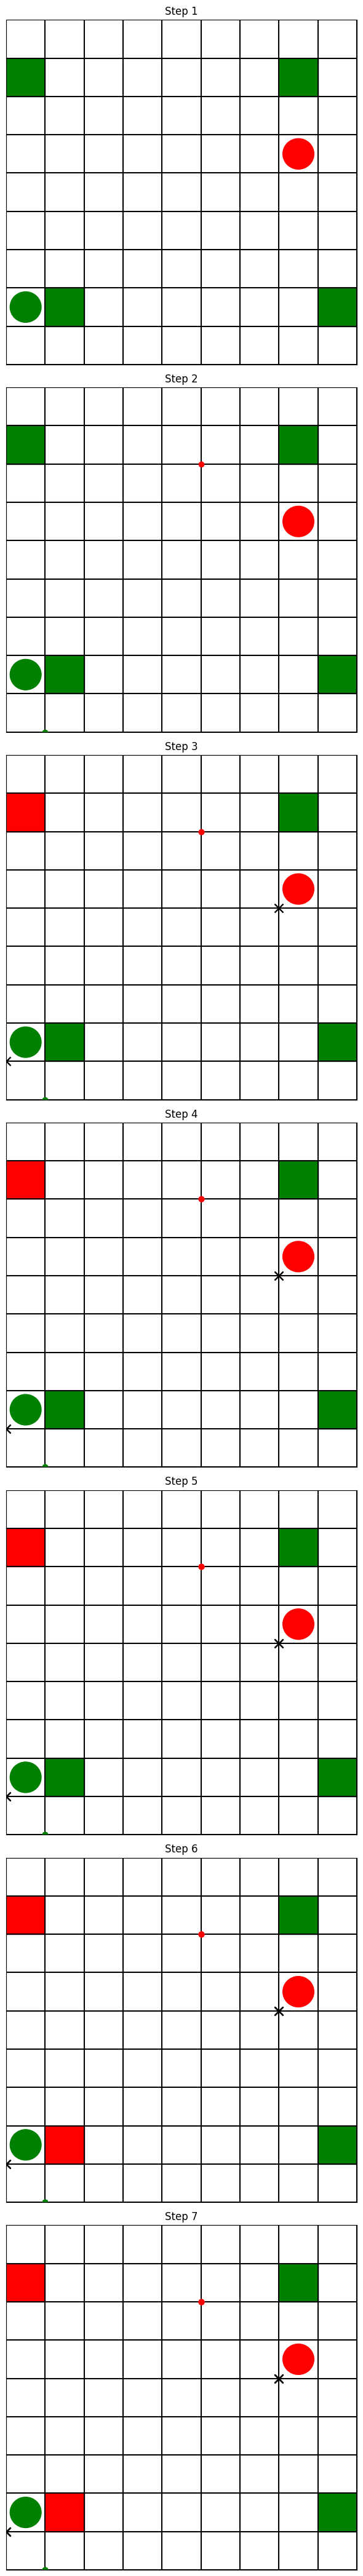

   Working Machines
0                 5
1                 5
2                 4
3                 4
4                 4
5                 3
6                 3


In [12]:
import random
import networkx as nx
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt

# Toggle to enable/disable A* path planning
USE_ASTAR = True

class MachineAsset:
    def __init__(self, unique_id, x, y, is_broken):
        self.unique_id = unique_id
        self.x = x
        self.y = y
        self.is_broken = is_broken

class RepairAgent(Agent):
    COLORS = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.assets_to_repair = []
        self.movement_history = []
        self.graph = nx.Graph()
        self.source_node = None
        self.target_node = None
        self.path_to_asset = []
        self.path = []

    def step(self):
        if not self.assets_to_repair:
            self.find_assets_to_repair()
            if self.assets_to_repair:
                asset = self.assets_to_repair.pop()
                self.target_node = (int(asset.x), int(asset.y))
                self.build_pathfinding_graph()
        else:
            if not self.graph:
                asset = self.assets_to_repair.pop()
                self.build_pathfinding_graph()
                if USE_ASTAR:
                    path = self.find_path_to_asset(asset)
                else:
                    path = self.find_random_path_to_asset(asset)
                if path:
                    self.follow_path(path)
            else:
                if self.path:
                    next_position = self.path.pop(0)
                    self.move_towards(next_position)

    def find_assets_to_repair(self):
        self.assets_to_repair = [agent.asset for agent in self.model.schedule.agents if isinstance(agent, MachineAgent) and agent.asset.is_broken]

    def build_pathfinding_graph(self):
        self.graph.clear()
        for agent in self.model.schedule.agents:
            if isinstance(agent, MachineAgent):
                pos = agent.pos
                neighbors = self.model.grid.get_neighborhood(pos, moore=True, include_center=True)
                for neighbor in neighbors:
                    if self.model.grid.is_cell_empty(neighbor):
                        self.graph.add_edge(pos, neighbor)

    def find_path_to_asset(self, asset):
        start = (int(self.pos[0]), int(self.pos[1]))
        goal = (int(asset.x), int(asset.y))
        try:
            path = nx.astar_path(self.graph, start, goal)
            return path
        except nx.NetworkXNoPath:
            raise Exception("No valid path to the asset.")

    def find_random_path_to_asset(self, asset):
        # Generate a random path (for visualization purposes)
        current_pos = (int(self.pos[0]), int(self.pos[1]))
        target_pos = (int(asset.x), int(asset.y))
        path = [current_pos]
        while current_pos != target_pos:
            neighbors = self.model.grid.get_neighborhood(current_pos, moore=True, include_center=True)
            valid_neighbors = [neighbor for neighbor in neighbors if self.model.grid.is_cell_empty(neighbor)]
            if valid_neighbors:
                next_pos = random.choice(valid_neighbors)
                path.append(next_pos)
                current_pos = next_pos
            else:
                break
        return path

    def follow_path(self, path):
        self.path = path
        self.movement_history.extend(path)
        if self.path:
            next_position = self.path.pop(0)
            self.move_towards(next_position)

    def move_towards(self, position):
        possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=True)
        other_agents = [agent for agent in self.model.schedule.agents if isinstance(agent, RepairAgent) and agent.unique_id != self.unique_id]
        valid_moves = [move for move in possible_moves if self.model.grid.is_cell_empty(move) or move in [agent.pos for agent in other_agents]]
        if valid_moves:
            potential_moves = []
            for move in valid_moves:
                if move in [pos for agent in other_agents for pos in agent.movement_history]:
                    potential_moves.append(move)
            if potential_moves:
                best_move = random.choice(potential_moves)
            else:
                best_move = min(valid_moves, key=lambda move: self.distance(move, position))
            self.record_movement()
            self.model.grid.move_agent(self, best_move)

    def record_movement(self):
        self.movement_history.append(self.pos)

class MachineAgent(Agent):
    def __init__(self, unique_id, model, asset, x, y):
        super().__init__(unique_id, model)
        self.asset = MachineAsset(unique_id, x, y, is_broken=False)
        self.x = x
        self.y = y
        self.asset.machine_agent = self

    def step(self):
        pass

class MachineModel(Model):
    def __init__(self, num_agents, grid_size, num_machines):
        self.num_agents = num_agents
        self.grid_size = grid_size
        self.num_machines = num_machines
        self.grid = MultiGrid(grid_size, grid_size, torus=True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.cycle = 0

        for i in range(self.num_agents):
            repair_agent = RepairAgent(i, self)
            self.schedule.add(repair_agent)
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(repair_agent, (x, y))

        machine_positions = self.generate_machine_positions()
        for i, (x, y) in enumerate(machine_positions):
            is_broken = False
            asset = MachineAsset(i, int(x), int(y), is_broken)
            machine_agent = MachineAgent(i + self.num_agents, self, asset, x, y)
            self.schedule.add(machine_agent)
            self.grid.place_agent(machine_agent, (int(x), int(y)))

        self.datacollector = DataCollector(
            model_reporters={"Working Machines": lambda model: sum(1 for agent in model.schedule.agents if isinstance(agent, MachineAgent) and not agent.asset.is_broken)}
        )

    def generate_machine_positions(self):
        machine_positions = []
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                machine_positions.append((x + 0.5, y + 0.5))
        return random.sample(machine_positions, self.num_machines)

    def step(self):
        self.cycle += 1
        if self.cycle % 3 == 0:
            self.break_machine()
        self.datacollector.collect(self)
        self.schedule.step()

    def break_machine(self):
        percentage_to_break = 0.2
        machine_agents = [agent for agent in self.schedule.agents if isinstance(agent, MachineAgent)]
        num_to_break = int(len(machine_agents) * percentage_to_break)
        for machine in random.sample(machine_agents, num_to_break):
            machine.asset.is_broken = True

# Create an instance of the MachineModel with a 10x10 grid and 5 machines
model = MachineModel(num_agents=2, grid_size=10, num_machines=5)

# Set the number of steps to run the model
num_steps = 7

# Create a figure to display the grid for each step
fig, axs = plt.subplots(num_steps, 1, figsize=(6, num_steps * 6))

# Run the model for the specified number of steps
for step in range(num_steps):
    # Perform one model step
    model.step()

    # Create a figure and axis for the grid visualization
    ax = axs[step]

    # Draw horizontal lines
    for y in range(10):
        ax.axhline(y, color='black')

    # Draw vertical lines
    for x in range(10):
        ax.axvline(x, color='black')

    # Add a boundary around the grid
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(True)

    # Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Set limits
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)

    # Calculate the cell size
    cell_size = 1.0

    # Add agents to the grid
    for agent in model.schedule.agents:
        x, y = agent.pos
        if isinstance(agent, RepairAgent):
            color = RepairAgent.COLORS[agent.unique_id % len(RepairAgent.COLORS)]
            ax.add_patch(plt.Circle((x + 0.5, y + 0.5), 0.4 * cell_size, color=color))
        elif isinstance(agent, MachineAgent):
            if agent.asset.is_broken:
                ax.add_patch(plt.Rectangle((x, y), 1.0, 1.0, color='red'))
            else:
                ax.add_patch(plt.Rectangle((x, y), 1.0, 1.0, color='green'))

    # Plot the movement of repair agents
    for agent in model.schedule.agents:
        if isinstance(agent, RepairAgent):
            color = RepairAgent.COLORS[agent.unique_id % len(RepairAgent.COLORS)]
            if agent.movement_history:
                x, y = zip(*agent.movement_history)
                ax.plot(y, x, marker='o', color=color)

            if USE_ASTAR:
                # Draw lines to show the paths taken by repair agents (A*)
                if agent.path_to_asset:
                    x, y = zip(*agent.path_to_asset)
                    ax.plot(y, x, linestyle='-', color=color)
            else:
                # Draw lines to show the paths taken by repair agents (random)
                if len(agent.movement_history) > 1:
                    for i in range(1, len(agent.movement_history)):
                        x0, y0 = agent.movement_history[i - 1]
                        x1, y1 = agent.movement_history[i]
                        ax.plot([y0 + 0.5, y1 + 0.5], [x0 + 0.5, x1 + 0.5], linestyle='--', color=color)

            # Check for collisions
            collision_positions = [pos for pos in agent.movement_history if agent.movement_history.count(pos) > 1]
            if collision_positions:
                ax.scatter(*zip(*collision_positions), marker='x', color='black', s=100)

    # Update movement history after plotting
    for agent in model.schedule.agents:
        if isinstance(agent, RepairAgent):
            agent.record_movement()

    # Set the title for the step
    ax.set_title(f"Step {step + 1}")

    # Save the visualization as an image file
    filename = f"visualization_step_{step + 1}.png"
    plt.savefig(filename)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Access the collected data
data = model.datacollector.get_model_vars_dataframe()
print(data)


